In [1]:
# Full imports
import gym
import cv2

# Partial imports
from gym import spaces
from math import cos, sin, pi

# Aliased imports
import numpy as np
import matplotlib.pyplot as plt


In [166]:
class TelesketchEnv(gym.Env):
    metadata = {"render_modes": ["image"]}

    def __init__(self, ref_canvas, sim_func, segment_length=5, stroke_thickness=5, render_mode=None) -> None:
        # Save ref image & sim func
        self.ref_canvas = self._to_norm_gray(ref_canvas)
        self.sim_func = sim_func
        self._reset_called = False

        # Save segment params
        self.segment_length = segment_length
        self.stroke_thickness = stroke_thickness
        
        # Define action space
        self.action_space = spaces.Discrete(8)

        # Define observation space
        self.observation_space = spaces.Dict(
            {
                "loc": spaces.Box(np.array((0, 0)), np.array(self.ref_canvas.shape), dtype=int),
                "canvas": spaces.Box(0, 255, shape=self.ref_canvas.shape, dtype=np.float32)
            }
        )

        # Assert correct render mode is selected
        assert render_mode is None or render_mode in self.metadata["render_modes"], "{render_mode} not supported"
        self.render_mode = render_mode

        self.window = None
        self.clock = None

    def _to_norm_gray(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(float) / 255
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        return img

    def _get_obs(self):
        return {"loc": self._loc, "canvas": self._canvas}
    
    def _get_info(self):
        return {"sim": self.sim_func(self._canvas, self.ref_canvas)}

    def _compute_rewards(self, ref_canvas, new_canvas, old_canvas):
        old_sim = self.sim_func(ref_canvas, old_canvas)
        new_sim = self.sim_func(ref_canvas, new_canvas)

        return 1 if new_sim > old_sim else 0
 
    def reset(self, loc=(0, 0), seed=None,):
        super().reset(seed=seed)

        self._loc = np.array(loc)
        self._canvas = np.full(self.ref_canvas.shape + (3,), 255, dtype=np.uint8)
        self._canvas = self._to_norm_gray(self._canvas)
        #self._canvas = cv2.line(self._canvas, (0, 0), (250, 250), (0, 0, 0), 5)

        # Reset flag
        self._reset_called = True

        return self._get_obs(), self._get_info()
    
    def step(self, action):
        # Check action is correct and reset has been called
        assert action >= 0 and action < self.action_space.n, "Action is not valid"
        assert self._reset_called, "Reset must be called before step"

        # Compute target x, y
        x = cos(action * pi / 4) * self.segment_length
        y = sin(action * pi / 4) * self.segment_length

        # Compute new states
        new_loc = self._loc + np.floor(np.array([x, -y])).astype(int)

        new_canvas = cv2.line(self._canvas, self._loc, new_loc, (0, 0, 0), self.stroke_thickness)

        # Compute rewards
        reward = self._compute_rewards(self.ref_canvas, new_canvas, self._canvas)

        # Update state
        self._loc = new_loc
        self._canvas = new_canvas

        return self._get_obs(), reward, None, False, self._get_info()

    def render(self):
        if self.render_mode == "image":
            self._plt_render()

    def _plt_render(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

        ref = cv2.cvtColor(self.ref_canvas, cv2.COLOR_GRAY2BGR) * 255
        gen = cv2.cvtColor(self._canvas, cv2.COLOR_GRAY2BGR) * 255

        ax1.imshow(ref, cmap="gray")
        ax2.imshow(gen, cmap="gray")

        ax1.set_title("Ref. Canvas")
        ax2.set_title("Env. Canvas")

        plt.show()
        

In [167]:
# Ref canvas
ref_canvas = np.full((250, 250, 3), 255, dtype=np.uint8)
ref_canvas = cv2.line(ref_canvas, (0, 0), (250, 250), (0, 0, 0), 5)

# Sim func
def rmse_sim(x, y):
    return np.sqrt(np.sum((x - y) ** 2))



In [168]:
# Init env
env = TelesketchEnv(ref_canvas, rmse_sim, 5, 5, "image")
env.reset()

({'loc': array([0, 0]),
  'canvas': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)},
 {'sim': 245.4995})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


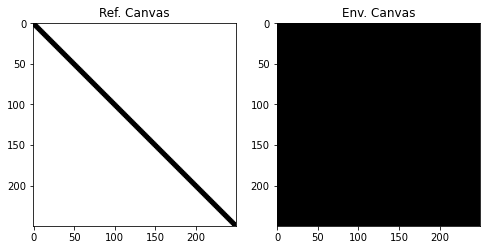

In [169]:
env.render()

In [171]:
env._canvas

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)